In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns
snb_name=''


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [4]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1994-12-31,277.550965,269.653193,275.538173,280.364381,282.353681,0.418400,0.042067,0.175902,0.609468,1.157299,...,4.278700e-02,0.244910,2.204337e+00,9.508158,12.666667,0.0,0.0,0.0,99.5,NaN
1995-01-01,275.295693,266.263109,272.240492,278.694118,280.001180,0.658229,0.202812,0.432163,0.823823,1.277020,...,1.246384e-03,0.028803,6.238064e-01,4.730884,13.202166,0.0,0.0,0.0,101.5,NaN
1995-01-02,270.636817,259.516378,266.948412,274.967590,275.929394,1.101060,0.086458,0.786270,1.408853,2.030923,...,0.000000e+00,0.000282,3.076210e-01,4.666833,13.777377,0.0,0.0,0.0,104.5,NaN
1995-01-03,270.011008,258.575369,266.081628,274.420921,275.120728,0.764851,-0.011602,0.508240,0.993407,1.535550,...,9.256200e-05,0.000750,6.673230e-02,2.185054,14.020457,0.0,0.0,0.0,108.5,NaN
1995-01-04,267.446374,254.016962,263.527209,272.213563,272.939673,0.120216,-0.304496,-0.124319,0.238352,0.885682,...,0.000000e+00,0.000000,1.295715e-03,0.004874,14.016847,0.0,0.0,0.0,108.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,275.322978,268.382351,273.969119,277.588342,278.764988,0.195226,-0.134346,0.006458,0.333897,0.745479,...,5.369835e-04,0.006503,5.396426e-01,8.251267,49.743682,0.0,0.0,0.0,314.5,645.0
2019-12-28,273.892546,265.744367,272.140043,276.233376,277.770658,0.008387,-0.202706,-0.101017,0.061470,0.372830,...,0.000000e+00,0.000018,7.324488e-04,0.007052,49.682310,0.0,0.0,0.0,314.5,601.0
2019-12-29,274.392543,268.806934,273.574397,275.882679,277.250389,0.065759,-0.164996,-0.088820,0.139964,0.625102,...,0.000000e+00,0.000279,2.334687e-03,0.010269,49.631769,0.0,0.0,0.0,314.5,557.0
2019-12-30,273.913902,268.834763,273.384392,275.294353,276.506228,0.050482,-0.248518,-0.113659,0.164926,0.489538,...,2.999676e-08,0.001139,1.645380e-02,0.035844,49.594465,0.0,0.0,0.0,314.5,530.0


In [7]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 0.5, 10)
epsilon_range=np.logspace(-2.2, -0.2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=3
test_size=730

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=0.0879922543569107
eps=0.00630957344480193


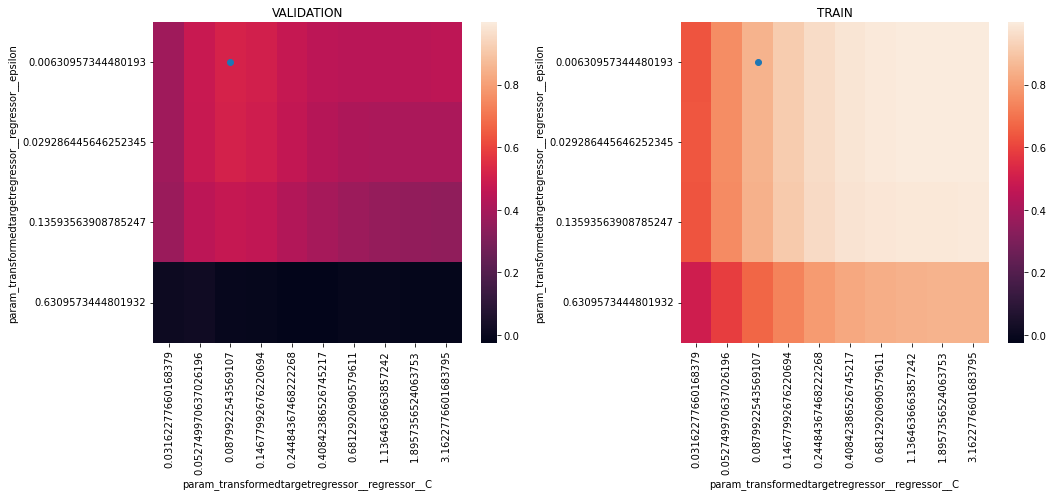

In [17]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [6]:
C=0.0879922543569107
eps=0.00630957344480193

In [23]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

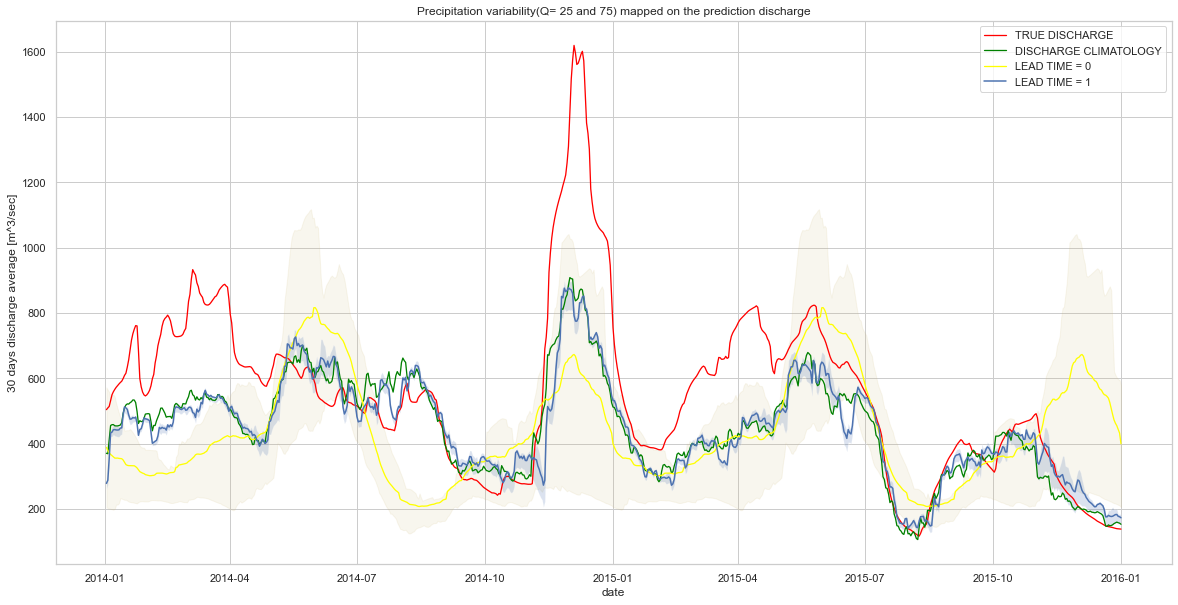

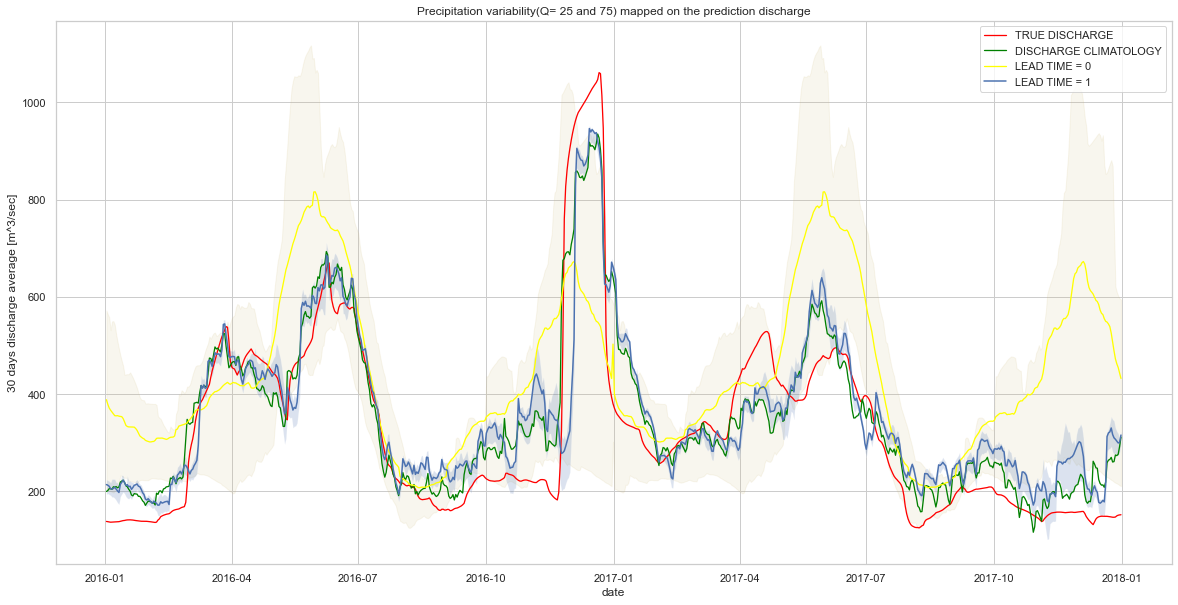

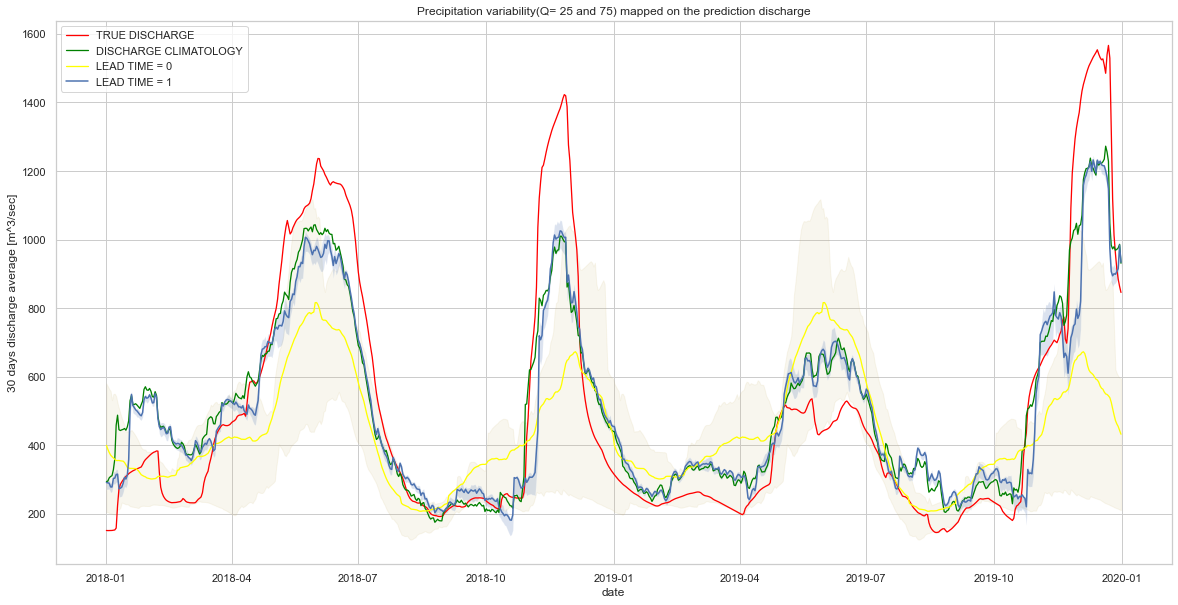

In [24]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

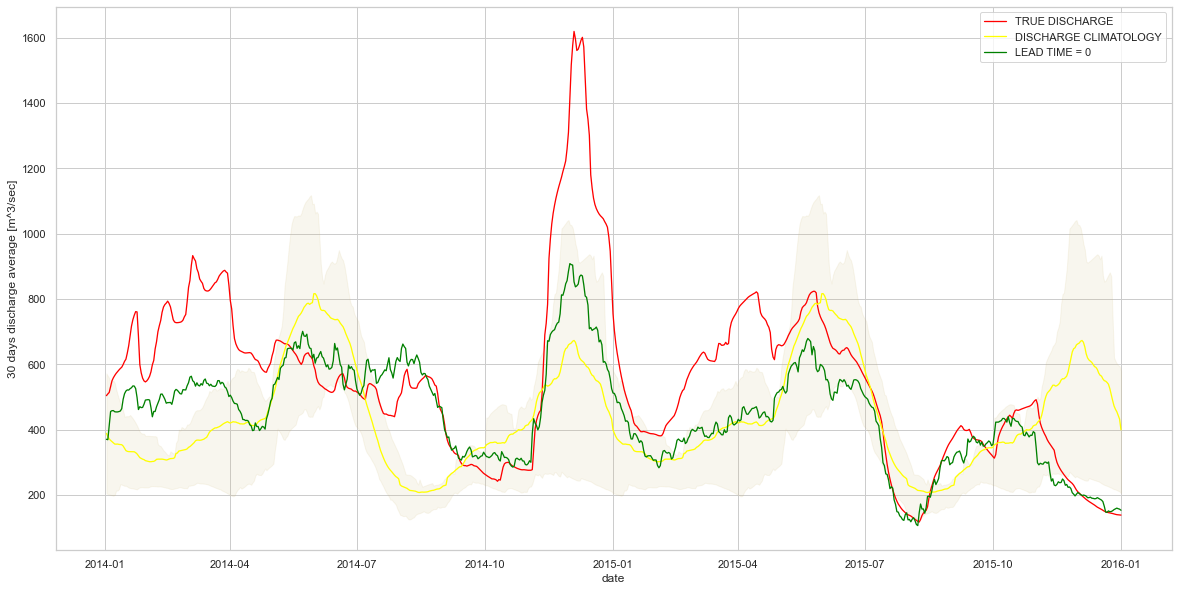

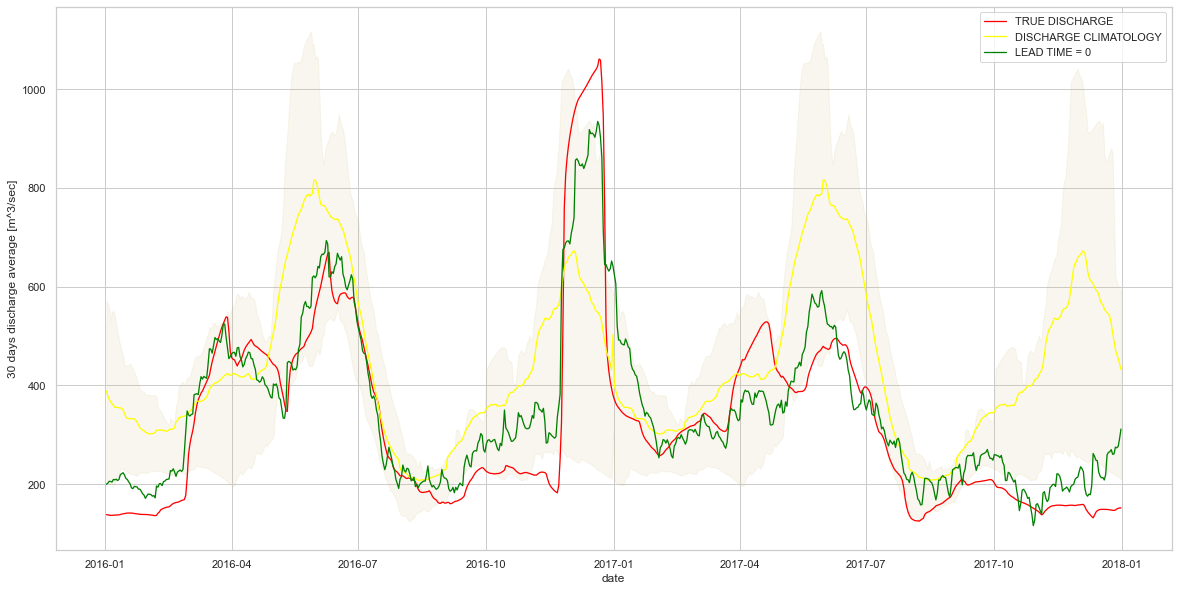

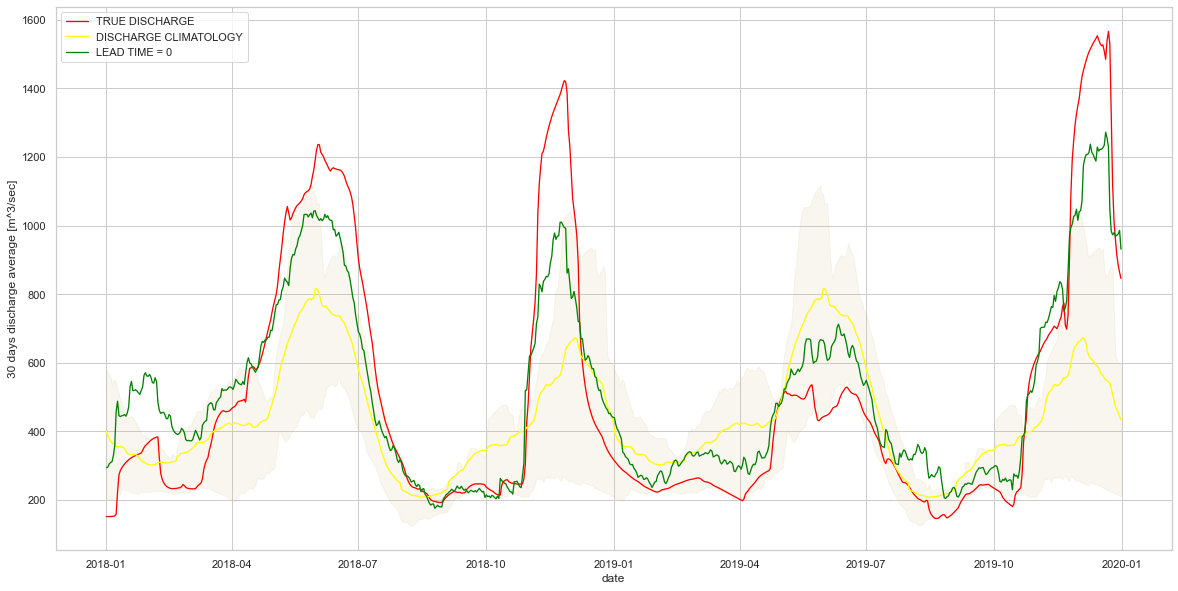

In [25]:
    prediction=predictions
    splits=prediction['split'].max()
    for i in range(splits+1):
        query=f'split=={i}'
        #query='split==' + str(i)
        pred=prediction.query(query)
        pred.loc[:,'date']= pred.index

        ax,fig=plt.subplots(figsize=(20,10))
        #plot the real
        sns.lineplot(y=("true_runoff"),x="date",data=pred,color='red',linewidth=1.3,legend='auto')
        sns.lineplot(y=("runoff_clim"),x="date",data=pred,color='yellow',linewidth=1.3,legend='auto')
        sns.lineplot(y=("trueTP"),x="date",data=pred,color='green',linewidth=1.3,legend='auto')


        #plot the clim_distr
        lt1=pred[["runoff_clim_25","runoff_clim_75"]]
        #lt1.columns=np.repeat('climatologia_lt1_ensemple_prec',3)
        #sns.lineplot(data=lt1["climTP_lt1"],legend='auto')
        plt.fill_between(x=lt1.index, y1=lt1['runoff_clim_25'], y2=lt1['runoff_clim_75'], alpha=0.12,color='y')

        """
        #plot the lead_time_
        lt4=pred[["climTP_lt4","climTP_lt4_Q25","climTP_lt4_Q75"]]
        #lt4.columns=np.repeat('climatologia_lt4_ensemple_prec',3)
        sns.lineplot(data=lt4["climTP_lt4"], palette=['green'],legend='auto')
        plt.fill_between(x=lt4.index, y1=lt4['climTP_lt4_Q25'], y2=lt4['climTP_lt4_Q75'], alpha=0.2)
        """

        plt.ylabel('30 days discharge average [m^3/sec]')

        plt.legend(['TRUE DISCHARGE', 'DISCHARGE CLIMATOLOGY', 'LEAD TIME = 0'])    
        plt.title("")

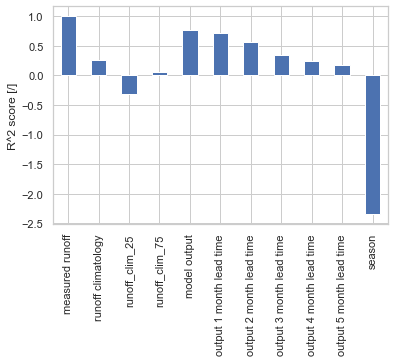

In [26]:
from test import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

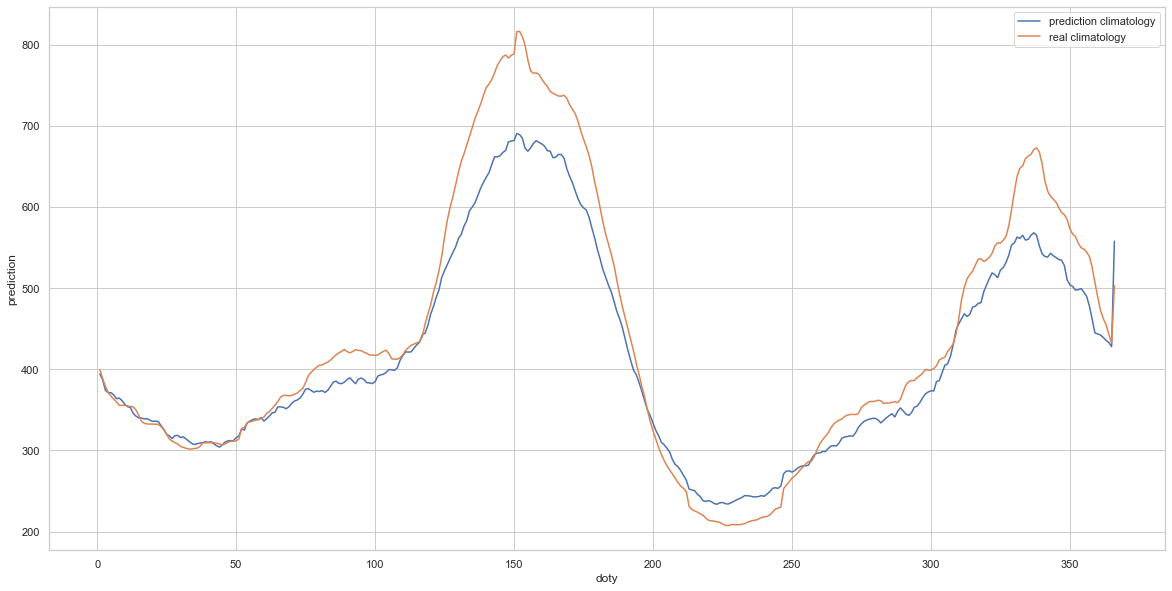

In [8]:

predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, 23)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [28]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_ITC1_0037.joblib']